
<div align="center"><img width="275" height="50" src="http://zillow.mediaroom.com/image/Zillow_Wordmark_Blue_RGB.jpg" /> </div> 

<div align="center"> <h1>Regression Project</h1> 
  <h6> by David Berchelmann -- March 24, 2021 </h6> </div>
  
  ------------------------------------------------

<div align="center"><img width="800" height="50" src="https://cdn-assets-s3.streeteasy.com/assets/svg/footer-f3b296bd4be445e92b2d0fd4b1d3c1050d30933b14e76d7b2fcf8215bb01ba1a.svg" /> </div>

-----

-------

<h1> Welcome! </h1>

The following jupyter notebook will take you through my regression project focusing on Zillow. The dataset comes from a SQL database and can also be accessed via Kaggle.com. 

All of the files and notebooks for this project can be accessed via the github repostiory located at --> https://github.com/DBerchelmann/zillow_regression_project



----

<h1> Executive Summary </h1>

------

<h4><b>The Problem</b></h4>

- The company is needing to predict home values of single unit properties in the Southern California area that the tax district assesses. 

<h4><b>The Goal</b></h4>

- My goal is to develop a linear regression based machine learning model that can accurately predict home values of single unit properties based on data from May-August of 2017.

<h4><b>The Process</b></h4>

  * Acquire the Data
  * Prepare 
  * Explore 
  * Model
  * Create Recommendations Based On Findings 
  
<h4><b>The Findings</b></h4>

- My choice of model(linear regression) beats the baseline with an R^2 of 39.35%. 

- The bulk of the property data is for properties under $1.68 million dollars. my linear regression model begins to under value properties as the value increases over the upper threshold. 
    
- More refinement, feature creation, and data will be needed to create a more honed in prediction model.
    
    
 
-------

<h3><u>Visualization of Final Results:</u></h3>

<div align="center"><img width="800" height="50" src="https://i.ibb.co/BcGxg4F/regress-zillow-model.png" /> </div>


----------


-------




<h3><u>Environment Setup</u></h3>

In [1]:
# packages for data analysis & mapping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import sqrt
import seaborn as sns
import plotly.express as px
from datetime import date 



# modeling methods
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE 
import sklearn.preprocessing



# address warnings
import warnings
warnings.filterwarnings("ignore")

# acquire, prep, train, & explore functions
from wrangle import get_connection, new_zillow_data, get_zillow_data, clean_zillow, split_data, wrangle_zillow, train_validate_test
import explore



<h4> Data Validation </h4>

 - Before the data was brought in through the acquire file, I invenstigated it further in SQL. Below are a few of my findings:
     - Some properties were labeled as 'single family residential' but had a unit count of more than 1
     - There were a number of properties that lacked location info (zip, lat, long, fips), these will be dropped in prep
     - Bedrooms and Bathrooms both have rows that have a value of 0. This too wil be dealt with in the prep stage

---
<h3><u>Acquire the Data</u></h3>

----

In [2]:
df = get_zillow_data()

In [3]:
print(f'My original dataframe is coming in with {df.shape[0]} rows and {df.shape[1]} columns.')

My original dataframe is coming in with 39696 rows and 16 columns.


In [4]:
df.isna().sum()

parcelid                            0
propertylandusetypeid               0
propertylandusedesc                 0
unitcnt                         14719
transactiondate                     0
calculatedfinishedsquarefeet      114
bedroomcnt                          0
bathroomcnt                         0
fips                                0
regionidzip                        27
yearbuilt                         137
taxvaluedollarcnt                   1
latitude                            0
longitude                           0
assessmentyear                      0
taxamount                           1
dtype: int64

<h4> <b>I'm interested in outliers within the tax appraised value (taxvaluedollarcnt) column. Let's investigate visually and with IQR.</b></h4>

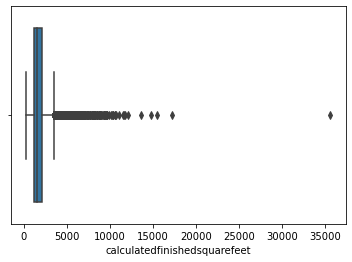

In [5]:
sns.boxplot(data = df, x = 'calculatedfinishedsquarefeet')
plt.show()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

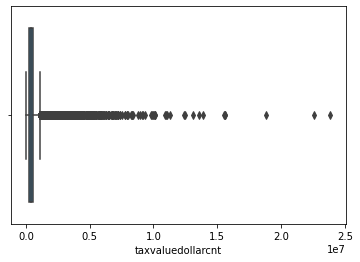

In [6]:
sns.boxplot(data = df, x = 'taxvaluedollarcnt')

In [7]:
q1, q3 = df.taxvaluedollarcnt.quantile([.25, .75])

iqr = q3 - q1

upperbound = q3 + 3.0 * iqr
lowerbound = q1 - 3.0 * iqr

print(f'The upper bound quartile is {upperbound} sqft while our lower bound quartile is {lowerbound}. These outliers will be addressed in prep')

The upper bound quartile is 1679155.0 sqft while our lower bound quartile is -888592.0. These outliers will be addressed in prep


-----

<h3>Outlier Takeaway</h3>

- While there were outliers within square footage, it was found that there could be better accuracy with the model by not touching them and instead focusing on the outliers with tax appraised value. 
- The dataset only includes properties who have a tax assessed value of less than $1,680,000.00

-----

<h3>Other Takeaways From Acquire</h3>
- Used my get_zillow_data() function to bring the data from SQL using the query:

    ```
    SELECT parcelid, propertylandusetypeid, propertylandusedesc, unitcnt, 
                 transactiondate, calculatedfinishedsquarefeet, bedroomcnt, 
                 bathroomcnt, fips, regionidzip, yearbuilt, taxvaluedollarcnt, latitude, longitude,  
                 assessmentyear, taxamount 
                 FROM predictions_2017 
                 JOIN properties_2017 using (parcelid)\
                 JOIN propertylandusetype using (propertylandusetypeid) 
                 WHERE month(transactiondate) >= 05 and month(transactiondate) <= 08 
                 AND propertylandusetypeid > 250 
                 AND propertylandusetypeid < 280  
                 AND propertylandusetypeid != 270  
                 AND propertylandusetypeid != 271 
                 OR unitcnt = 1 
                 ORDER BY unitcnt DESC; 
                                                ``` 

- Running df.shape showed (62159 rows, 16 columns)
- There aren't a whole lot of nulls to filter out as this had been dealt with in SQL
     - Of the nulls that are present (minus unit count), they exist in:
         - completed square feet (119) 
         - year built (144)
         - regionid zip (36)
         - tax amount (4)
         - tax value dollar count (1)
     - These nulls will be handled in the prepare file
- The unit count column will be dropped so those nulls will not be an issue. It's purpose will be addressed in the prep stage
- Columns will be renamed for readability. These can be found in the data dictionary

     
 -----

----

<h3>Clean/Prep the Data</h3>

----

 - To clean the data, I will be utilizing the clean_zillow(df) function that is within the wrangle.py file
     - We will first look at the removal of outliers for the tax_assessed_value and find a distribution, while still right skewed, much less affected by high values outside the upper bound quartile.

In [8]:
df = clean_zillow(df)

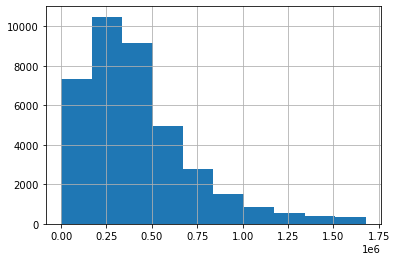

In [9]:
df.tax_assessed_value.hist()
plt.show()

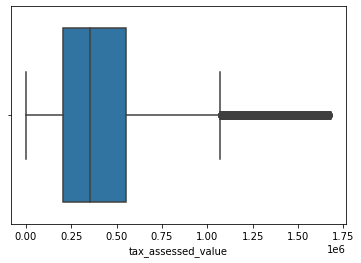

In [10]:
sns.boxplot(data = df, x = 'tax_assessed_value')
plt.show()

The following was done to prep the data. This is all heald within the ```clean_zillow``` function located in the ```wrangle.py``` file which is located in the github repository linked at the beginning of this notebook.

- Identify properties that do not qualify as single family homes
    
    
- Delete properties that do not qualify as single family homes
    
    
- Create new column (age_of_home)
    today = pd.to_datetime('today')
    df['age_of_home'] = today.year - df['yearbuilt']
    
               
- Remove NaNs from finished square feet
   
    
- Replace '0' bathrooms with the median which is 2
    
  
- Replace '0' bedrooms with the median which is 3
    

    
- Remove NaNs from zip code
    

- Remove NaNs from tax amount
    
  
- Remove NaNs from year_built
    
- Remove NaNs from tax value dollar count
  
- Remove decimal from latitude and longitude
   
- Convert latitude and longitude to positonal data points using lambda funtion (i.e. putting a decimal in the correct place)
   
- Remove properties with a unit count greater than 1
    
- Delete properties that do not qualify as single family homes
    
- Drop unitcnt column
    
- Remove properties with a tax value greater than or equal to 1.68 million dollars and sqfootage greater than 3500 (these are outliers causing issues)
    
- Convert age_of_home column from float to an integer (this removes the decimal point)
  
- Create bathrooms per sqft
    ``` df['bath_pers_qft'] = df['bathroomcnt'] / df['calculatedfinishedsquarefeet'] ```
    
- Create bedrooms per sqft
   ``` df['beds_pers_qft'] = df['bedroomcnt'] / df['calculatedfinishedsquarefeet']```
    
- Rename columns (new column name is after the colon (:))
  
     - 'parcelid':'parcelid'
     - 'propertylandusetypeid':'landuse_id'
     - 'propertylandusedesc':'landuse_desc'
     - 'transactiondate':'last_sold_date'
     - 'calculatedfinishedsquarefeet':'total_sqft'
     - 'bedroomcnt':'bedroom_quanity'
     - 'bathroomcnt':'bathroom_quanity',
     - 'fips':'fips'
     - 'regionidzip':'zip_code'
     - 'yearbuilt':'year_built'
     - 'taxvaluedollarcnt':'tax_assessed_value'
     - 'latitude':'latitude', 'longitude':'longitude',
     - 'assessmentyear':'tax_assess_yr'
     - 'taxamount':'property_tax'
     - 'age_of_home':'age_of_home'
     
   
- Set parcelid as the index
   
    
- drop un-needed columns
  - ```df.drop('landuse_id', axis=1, inplace=True)```
  -  ```df.drop('landuse_desc', axis=1, inplace=True)```
  -  ```df.drop('last_sold_date', axis=1, inplace=True)```
  -  ```df.drop('tax_assess_yr', axis=1, inplace=True)```
    

- convert columns to object
    
  -  ```df['zip_code'] = df['zip_code'].astype(object)```
  -  ```df['fips'] = df['fips'].astype(object)```
  -  ```df['year_built'] = df['year_built'].astype(object)```

-----
<h3> Prep Takeaways </h3>
    
   - This data set came in fairly messy with some NaNs (empty data), Mislabeled features (like a single family home showing as a 4 unit count property) and features like latitude and longitude that needed to be changed to their correct form.
   - Columns were renamed for ease of readbility 
   - Several new features (columns) were created
       - Age of home
       - Bathrooms Per Square Foot
       - Bedrooms Per Square Foot
   - There were three columns that had their data type changed from int to object. This was done to allow for scaling later on of numeric features
       
  - After the cleaning was complete, I used the split data set to transition the data into train, validate, & test dataframes
  
  -------

<h3><u>Data Dictionary</u></h3>



|   Feature      |  Data Type   | Description    |
| :------------- | :----------: | -----------: |
|  parcelid | int64   | --    |
| landuse_id     | float64 | --|
| landuse_desc   | object | --|
| last_sold_date  | object | --|
|  total_sqft  | float64   | --    |
| bedroom_quanity    | float64 | --|
| bathroom_quanity   | float64 | --|
| fips  | float64 | --|
|  zip_code | float64   | --    |
| year_built    | float64 | --|
| tax_assesed_value   | float64 | --|
| latitude  | float64 | --|
|  longitude  | float64   | --    |
| tax_assess_yr    | float64 | --|
| property_tax   | float64 | --|
| age_of_home  | int64 | --|


-----

<h3> Explore the Data </h3>

-----

<i>again, we will use functions from ```wrangle.py``` to clean our data, train/validate/test, & scale (on train data)</i>

In [11]:
df = wrangle_zillow()
train, validate, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, 'tax_assessed_value')

----

<h5>Let's examine a pairplot to get a better look at our quanitative variables</h5>

-----

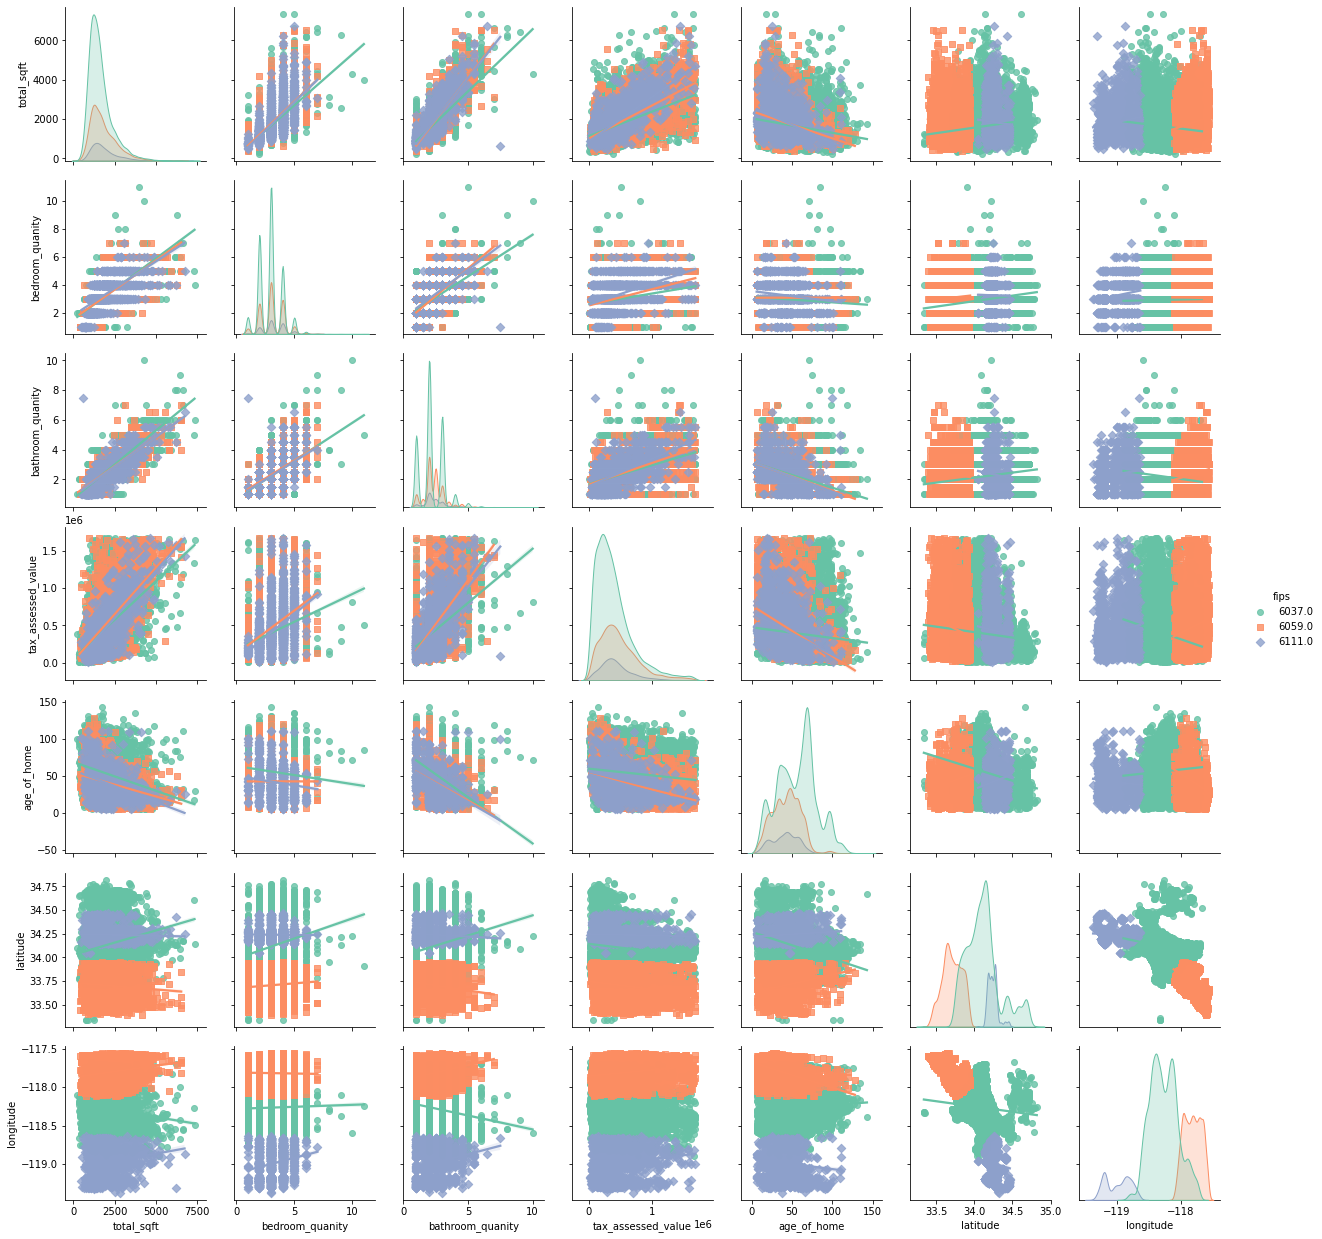

In [12]:
quant_vars = ['total_sqft', 'bedroom_quanity', 'bathroom_quanity', 'tax_assessed_value', 'age_of_home', 'latitude', 'longitude']
explore.plot_variable_pairs(train, quant_vars)

<h4>Pair Plot Takeaways</h4>

   - What stands out is that there looks to be definite correlation between total sqft/bedroom_quanity & sqft/bathroom_quanity
   - Tax assessed value seems to have the strongest correlation with bathroom_quanity and total_sqft
   - There is also a negative correlation between bathroom_quanity and age_of_home along with total_sqft & age of home
       - What this tells me is that older homes have less square footage and because of less space, they also had less bathrooms

----

<h4>Time For A Correlation Heat Map!</h4>

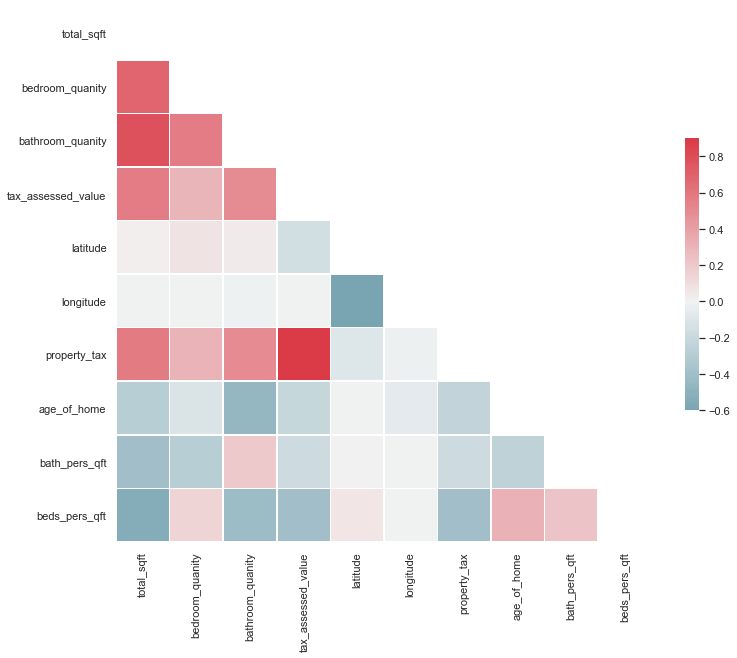

In [13]:
explore.corr_map(train)

<h4> Correlation Takeaways </h4>

 - Well, this heat map did a great job giving an additional visual of where our correlations exist. 
     - The darker the red, the stronger the postive correlation between variables. The darker the blue, the stronger the negative correlation between the two variables.
 - Time to run some correlation tests before looking at other data
 
<h4> Hypothesis Correlation Tests </h4>

In [14]:
# Set Confidence Interval and Alpha; check alpha.

confidence_interval = .95
alpha = round(1 - confidence_interval, 2)
print(f'alpha = {alpha}')

alpha = 0.05


Let's see if there is a relationship between bathrooms and total square feet like we saw above.
- <b>Null Hypothesis:</b> There is no relationship between bathroom quantity and total sqft.
- <b>Alternative Hypothesis:</b> There is a relationship between between bathroom quantity and total sqft.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.78


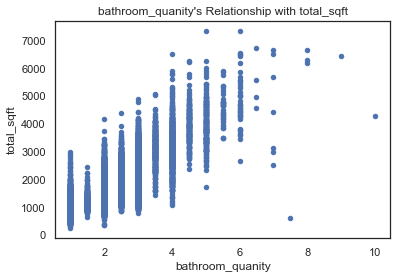

In [15]:
explore.correlation_exploration(train, 'bathroom_quanity', 'total_sqft')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bathrooms and total sqft.</h5>

-----

Let's see if there is a relationship between bathroom quantity and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between bathroom quantity and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between bathroom quantity and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.49


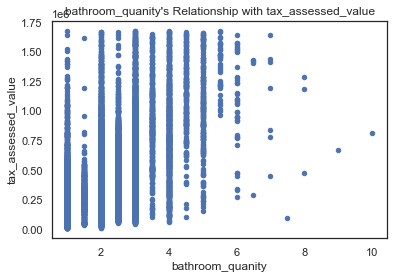

In [16]:
explore.correlation_exploration(train, 'bathroom_quanity', 'tax_assessed_value')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bathrooms and total sqft.</h5>

-----

Let's see if there is a relationship between total sqft and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between total sqft and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between total sqft and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.0 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = 0.3


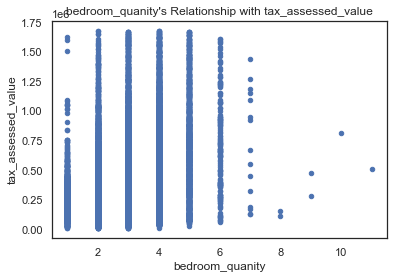

In [17]:
explore.correlation_exploration(train, 'bedroom_quanity', 'tax_assessed_value')

<h5>The correlation test confirmed what we thought and saw in the charts above. There is a relationship between bedrooms and total sqft.</h5>

-----

Let's see if there is a relationship between latitude and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between latitude and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between latitude and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 1.666624267399106e-123 and is less than alpha. There is 0.0% chance that we see these results by chance.
r = -0.16


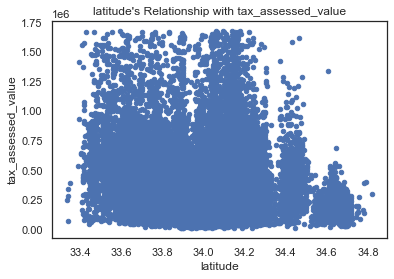

In [18]:
explore.correlation_exploration(train, 'latitude', 'tax_assessed_value')

Let's see if there is a relationship between latitude and tax appraised value.
- <b>Null Hypothesis:</b> There is no relationship between longitude and tax appraised value.
- <b>Alternative Hypothesis:</b> There is a relationship between longitude and tax appraised value.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


The p-value is: 0.8287487119874121 and we fail to reject the null hypothesis. There is 0.829% chance that we see these results by chance.
r = -0.0


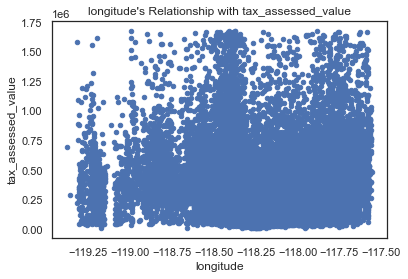

In [19]:
explore.correlation_exploration(train, 'longitude', 'tax_assessed_value')

----

<h4>Correlation Hypothesis Takeaways</h4>

- My big takeaway from the hypothesis testing is that while latitude is correlated with tax assessed value, longitude is not. This will be interesting to test out when we get to feature engineering and eventually modeling.
- The other items were all confirmed to be correlated after running a Pearson test. 

-----

<h3> Time for more charts! </h3>

 - Let's get a better look at the distriubtion of our plots in the Southern California area.
     - FIPS is a federal identifier for counties. 
        - 6037 - Los Angeles County, California
        - 6059 - Orange County, California
        - 6111 - Ventura County, California

<Figure size 864x864 with 0 Axes>

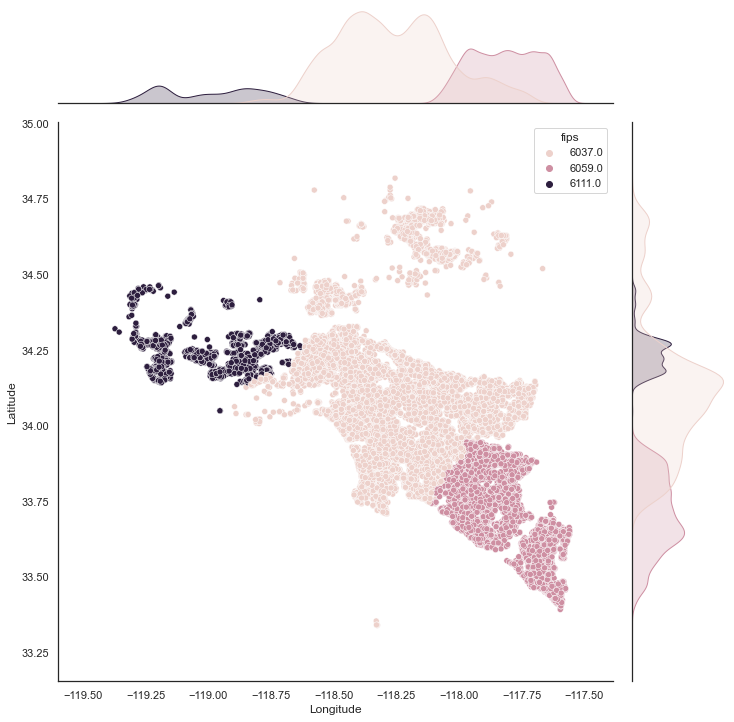

In [20]:
# exploratory analysis
# location distribution
plt.figure(figsize=(12,12))
fig=sns.jointplot(data = train, x=train.longitude.values, y=train.latitude.values, size=10, hue='fips')
fig.set_axis_labels('Longitude','Latitude')
#plt.colorbar(orientation="vertical",fraction=0.07)
plt.show()

 - While the above plot is nice to look at, I can give you a much better and more interactive visual for each data point

In [21]:
px.set_mapbox_access_token(open(".mapbox_token").read())

fig = px.scatter_mapbox(train, lat="latitude"  ,lon="longitude" , color="bedroomcnt", size="total_sqft",
                        center={"lat": 34.0522, "lon": -118.2437},
                        color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)
fig.show()

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['total_sqft', 'bedroom_quanity', 'bathroom_quanity', 'fips', 'zip_code', 'year_built', 'tax_assessed_value', 'latitude', 'longitude', 'property_tax', 'age_of_home', 'bath_pers_qft', 'beds_pers_qft'] but received: calculatedfinishedsquarefeet